In [1]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split


import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel, AdamW
from transformers import get_linear_schedule_with_warmup
import time

from utils import *
from Custom_Dataset_Class import ICAADDataset1
from Bert_Classification import Bert_Classification_Model
from RoBERT import RoBERT_Model

from BERT_Hierarchical import BERT_Hierarchical_Model
import warnings
warnings.filterwarnings("ignore")

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Data preprocessing and segmentation:

### 1. Preprocessing:
The preprocessing step goes as follows:
1. Remove all documents with fewer than 250 tokens. We want to concentrate only on long texts
2. Consolidate the classes by combining those that are similar. (e.g.: "Credit card" or "prepaid card" complaints) :
 * Credit reporting‘ to ‘Credit reporting, credit repair services, or other personal consumerreports‘.
 * ‘Credit card‘ to ‘Credit card or prepaid card‘.
 * ‘Payday loan‘ to ‘Payday loan, title loan or personal loan‘1
 * ‘Virtual currency‘ to ‘Money transfer, virtual currency or money servic
3. Remove all non-word characters
4. Encode the labels
5. Split the dataset in train set (80%) and validation set (20%).

### 2. Segmentation and tokenization:
First, each complaint is split into 200-token chunk with an overlap of 50 between each of them. This means that the last 50 tokens of a segment are the first 50 of the next segment.  
Then, each segment is tokenized using BERT's tokenizer. This is needed for two main reasons:
1. BERT's vocabulary is not made of just English words, but also subwords and single characters
2. BERT does not take raw string as inputs. It needs:
    - token ids: those values allow BERT to retrieve the tensor representation of a token
    - input mask: a tensor of 0s and 1s that shows whether a token should be ignored (0) or not (1) by BERT
    - segment ids: those are used to tell BERT what tokens form the first sentence and the second sentence (in the next sentence prediction task)  
    
The parameter `MAX_SEQ_LENGTH` ensures that any tokenized sentence longer that that number (200 in this case) will be truncated.  
Each returned segment is given the same class as the document containing it.

PyTorch offers the `Dataset` and `DataLoader` classes that make it easier to group the data reading and preparation operations while decreasing the memory usage in case the dataset is large.  
We implemented the above steps in the `Custom_Dataset_Class.py` file. Our dataset class `ConsumerComplaintsDataset1` has a constructor (`__init__`) taking the necessary parameters to load the .csv file, segment the documents, and then tokenize them. It also preprocesses the data as explained in the preprocessing section.    
The two other important methods are the following:
- `__len__` returns the number of documents
- `__getitem__` is the method where most of the work is done. It takes a tensor of idx values and returns the tokenized data:


&nbsp;


As said above, there is differents approaches for overflowing tokens, we added the differents strategies (described in [the following paper](https://arxiv.org/abs/1905.05583)) via the use of the parameter `approach` in the initialisation of Consumer Complaints Dataset class, here is the differents value of the `approach` parameter to handle that situation :
- **all**: overflowing tokens from a document are used to create new 200 token chunk with 50 tokens overlap between them
- **head**: overflowing tokens are truncated. Only the first 200 tokens are used.
- **tail**: only the last 200 tokens are kept.

In [6]:

TRAIN_BATCH_SIZE=8
EPOCH=3
validation_split = .1
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#dataset=ConsumerComplaintsDataset1(
dataset=ICAADDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)

Loading BERT tokenizer...
Nettoyage des données


### 3. Fine-tuning on the 200 tokens chunks:
BERT is fine-tuned on the 200 tokens chunks

In our implementation, we put a neural network on top of the pooled output from BERT, each BERT's input token has a embeding as an output, the embedding of the `CLS` token (the first token) corresponds to the pooled output of the all sentence input (the 200 tokens chunk in our case).

The neural network is composed of a dense layer with a SoftMax activation function.

This Model corresponds to the class `Bert_Classification_Model` defined in the file `Bert_Classification.py`. This class inherits from `torch.nn.Module` which is the parent of all neural network models.

Then, in the function `train_loop_fun1` defined in `utils.py`, for each batch, the list of dictionaries containing the values for the token_ids, masks, token_type_ids, and targets are respectively concatenated into `torch.tensors` which are then fed into the model in order to get predictions and apply backpropagation according to the Cross Entropy loss.

#### First segmetation approach: all

in this approach, we will consider each chunk of 200 tokens as a new document, so if a document is split into 3 chunk of 200, tokens we will consider each chunks as a new document with the same label.\
We use this approach to fine tune BERT, so this model will be used as an input for RoBERT. 

![img/each_Chunk_as_Document.png](img/each_Chunk_as_Document.png)

In [7]:

lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=Bert_Classification_Model().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)


In [8]:
print(model)

Bert_Classification_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [9]:
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tm
    
    p=eval_loop_fun1(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("\t§§ model has been saved §§")
    torch.save(model, f"model1/model_epoch{epoch+1}.pt")    


=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 82 (0.00%), loss = 0.6782, time = 76.44 secondes ___

*** avg_loss : 0.68, time : ~161.0 min (9685.20 sec) ***

==> evaluation : avg_loss = 0.74, time : 135.78 sec

=====>	{'accuracy': 0.5430711610486891, 'nb exemple': 801, 'true_prediction': 435, 'false_prediction': 366}
	§§ model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 82 (0.00%), loss = 0.7360, time = 53.20 secondes ___

*** avg_loss : 0.65, time : ~126.0 min (7617.40 sec) ***

==> evaluation : avg_loss = 0.70, time : 150.18 sec

=====>	{'accuracy': 0.5767790262172284, 'nb exemple': 801, 'true_prediction': 462, 'false_prediction': 339}
	§§ model has been saved §§

=============== EPOCH 3 / 3 ===============

___ batch index = 0 / 82 (0.00%), loss = 0.6710, time = 116.83 secondes ___

*** avg_loss : 0.64, time : ~122.0 min (7370.65 sec) ***

==> evaluation : avg_loss = 0.72, time : 139.84 sec

=====>	{'accuracy': 0.575530

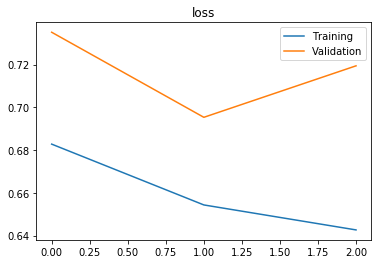

In [10]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

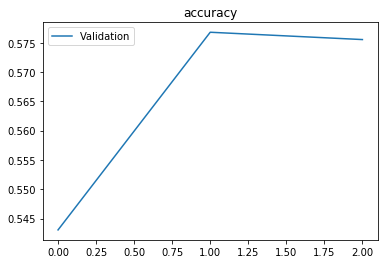

In [11]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

### Hierarchical Method

the Hierarchical methods applies to the ouputs of the Bert model (the embbeding)
The input text is firstly divided into k = L/510 fractions, which is fed into BERT to obtain the representation of the k text fractions. The representation of each fraction is the hidden state of the `[CLS]` tokens of the last layer. Then we use mean pooling, max pooling


#### Mean Pooling 

in this approach, we average the embedding of all k chunks across each dimensions.

![img/Mean_Pooling_Hierarchical.png](img/Mean_Pooling_Hierarchical.png)

In [12]:
TRAIN_BATCH_SIZE=3
EPOCH=3
validation_split = .1
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

dataset=ICAADDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

pooling_method="mean"
model_hierarchical=BERT_Hierarchical_Model(pooling_method=pooling_method).to(device)
optimizer=AdamW(model_hierarchical.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_hierarchical, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_hierarchical, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")
    torch.save(model_hierarchical, f"model_hierarchical/{pooling_method}_pooling/model_{pooling_method}_pooling_epoch{epoch+1}.pt")    

Loading BERT tokenizer...
Nettoyage des données

=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 219 (0.00%), loss = 0.3630, time = 9.59 secondes ___

*** avg_loss : 0.69, time : ~426.0 min (25613.06 sec) ***

==> evaluation : avg_loss = 0.71, time : 128.04 sec

=====>	{'accuracy': 0.5138888888888888, 'nb exemple': 72, 'true_prediction': 37, 'false_prediction': 35}
	§§ the Hierarchical mean pooling model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 219 (0.00%), loss = 0.4849, time = 14.38 secondes ___

*** avg_loss : 0.70, time : ~85.0 min (5113.74 sec) ***

==> evaluation : avg_loss = 0.70, time : 123.28 sec

=====>	{'accuracy': 0.5138888888888888, 'nb exemple': 72, 'true_prediction': 37, 'false_prediction': 35}
	§§ the Hierarchical mean pooling model has been saved §§

=============== EPOCH 3 / 3 ===============

___ batch index = 0 / 219 (0.00%), loss = 0.6644, time = 19.92 secondes ___

*** avg_loss : 0.69, time : ~87.0 mi

In [17]:
def get_data(fname):
    df = pd.read_csv(fname)
    df = df[['cleaned_contents', 'Discrimination_Label']]
    df = df.rename(columns = {'cleaned_contents':'text', 'Discrimination_Label':'label'})
    df.reset_index(inplace=True, drop=True)
    return df

In [18]:
test_df_preload = get_data('test_80_10_10.csv')

In [19]:
test_df_preload.to_csv('test.csv', index=False)

In [20]:
dataset=ICAADDataset1(
    file_location="test.csv",
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)

Nettoyage des données


In [39]:
# Creating data indices for training and validation splits:
test_indices = list(range(len(dataset)))
test_sampler = SubsetRandomSampler(test_indices)

In [40]:
test_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=test_sampler,
    collate_fn=my_collate1)

In [42]:
# Put model in evaluation mode
model_hierarchical.eval()

BERT_Hierarchical_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [44]:
output, target, val_losses_tmp=rnn_eval_loop_fun1(test_data_loader, model_hierarchical, device)

In [47]:
y_pred = np.argmax(output, axis=1)

In [64]:
dataset.label

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0])

In [65]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
print("Hireachical Mean Pooling")
print(classification_report(dataset.label, y_pred))

Hireachical Mean Pooling
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.55      1.00      0.71        44

    accuracy                           0.55        80
   macro avg       0.28      0.50      0.35        80
weighted avg       0.30      0.55      0.39        80



#### Max Pooling 

in this approach, we take the maximum embedding of all the k chunks across each dimensions.

![img/Max_Pooling_Hierarchical.png](img/Max_Pooling_Hierarchical.png)

In [67]:
TRAIN_BATCH_SIZE=3
EPOCH=3
validation_split = .1
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


dataset=ICAADDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

pooling_method="max"
model_hierarchical=BERT_Hierarchical_Model(pooling_method=pooling_method).to(device)
optimizer=AdamW(model_hierarchical.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_hierarchical, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_hierarchical, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")
    torch.save(model_hierarchical, f"model_hierarchical/{pooling_method}_pooling/model_{pooling_method}_pooling_epoch{epoch+1}.pt")    

Loading BERT tokenizer...
Nettoyage des données

=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 219 (0.00%), loss = 0.7650, time = 74.61 secondes ___

*** avg_loss : 0.69, time : ~88.0 min (5322.42 sec) ***

==> evaluation : avg_loss = 0.66, time : 131.73 sec

=====>	{'accuracy': 0.6527777777777778, 'nb exemple': 72, 'true_prediction': 47, 'false_prediction': 25}
	§§ the Hierarchical max pooling model has been saved §§

=============== EPOCH 2 / 3 ===============

___ batch index = 0 / 219 (0.00%), loss = 0.7522, time = 43.24 secondes ___

*** avg_loss : 0.67, time : ~86.0 min (5182.24 sec) ***

==> evaluation : avg_loss = 0.65, time : 128.52 sec

=====>	{'accuracy': 0.6944444444444444, 'nb exemple': 72, 'true_prediction': 50, 'false_prediction': 22}
	§§ the Hierarchical max pooling model has been saved §§

=============== EPOCH 3 / 3 ===============

___ batch index = 0 / 219 (0.00%), loss = 0.6293, time = 17.67 secondes ___

*** avg_loss : 0.64, time : ~90.0 min (

In [68]:
# Put model in evaluation mode
model_hierarchical.eval()

BERT_Hierarchical_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [72]:
dataset=ICAADDataset1(
    file_location="test.csv",
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)

Nettoyage des données


In [69]:
output, target, val_losses_tmp=rnn_eval_loop_fun1(test_data_loader, model_hierarchical, device)

In [70]:
y_pred = np.argmax(output, axis=1)

In [73]:
print("Hireachical Mean Pooling")
print(classification_report(dataset.label, y_pred))

Hireachical Mean Pooling
              precision    recall  f1-score   support

           0       0.56      0.14      0.22        36
           1       0.56      0.91      0.70        44

    accuracy                           0.56        80
   macro avg       0.56      0.52      0.46        80
weighted avg       0.56      0.56      0.48        80

